In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import datasets, preprocessing, ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

plt.style.use('ggplot')

In [2]:
# import previously cleaned data and remove unwanted column

housing = pd.read_csv('../../Machine_Learning_Project/data/Ames_HousePrice_withAddress_cleaned.csv')
housing.drop(['Unnamed: 0'], axis=1, inplace=True)


In [3]:
#dir(sklearn.ensemble)

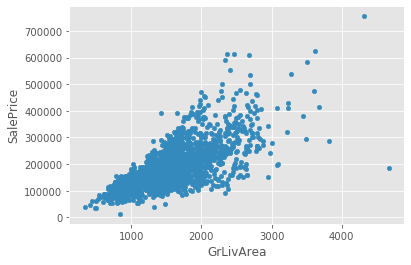

In [4]:
housing.plot.scatter(x='GrLivArea', y='SalePrice')

In [5]:
housing.shape

(2559, 64)

In [6]:
mean = np.mean(housing['SalePrice'])
std = np.std(housing['SalePrice'])
threshold = 3

# remove outliers
housing = housing[(housing['SalePrice'] < mean + threshold * std)]
housing = housing[housing['SalePrice'] > mean - threshold * std]
housing.shape

(2516, 64)

In [7]:
mean = np.mean(housing['GrLivArea'])
std = np.std(housing['GrLivArea'])
threshold = 3

# remove outliers
housing = housing[(housing['GrLivArea'] < mean + threshold * std)]
housing = housing[housing['GrLivArea'] > mean - threshold * std]
housing.shape

(2503, 64)

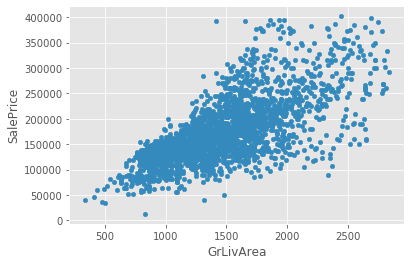

In [8]:
housing.plot.scatter(x='GrLivArea', y='SalePrice')

In [9]:
# remove visual outliers from the above scatterplot
housing = housing[(housing['GrLivArea'] <= 4000) & (housing['SalePrice'] > 60000)]

Below we see that a linear trend is much more present when the SalePrice is on log scale.

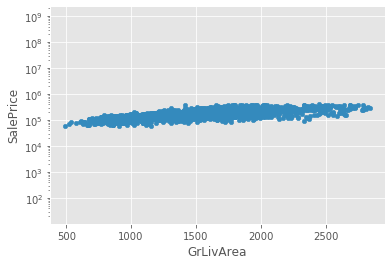

In [10]:
housing.plot.scatter(x='GrLivArea', y='SalePrice', logy=True)

In [11]:
housing.columns

Index(['GrLivArea', 'SalePrice', 'MSZoning', 'LotFrontage', 'LotArea',
       'LotShape', 'LandContour', 'LandSlope', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', 'Electrical',
       'LowQualFinSF', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'Fence', 'GeoRefNo', 'Prop_Addr', 'lat',
       'long', 'Baths', 'Class_1.5story', 'Class_1story_dev', 'Class_2story',
       'Class_2story_dev', 'Class_duplex', 'Class_split', 'Lot_Corner',
       'Lot_CulDSac', 'Lot_FR', 'Foundation_Concrete', 'Foundation_Other',
       'price_per_s

In [12]:
# Select what features will be used for the model 
X = housing[['GrLivArea', 'OverallQual', 'OverallCond', 
            'ExterQual', 'BsmtFinSF1', 'ScreenPorch',
            'TotalBsmtSF', 'KitchenQual', 'Fireplaces', 'GarageArea',
            'WoodDeckSF', 'MasVnrArea']].copy()

# Target variable on log scale
y = np.log(housing['SalePrice'])

In [13]:
X.isna().sum()

GrLivArea      0
OverallQual    0
OverallCond    0
ExterQual      0
BsmtFinSF1     1
ScreenPorch    0
TotalBsmtSF    1
KitchenQual    0
Fireplaces     0
GarageArea     1
WoodDeckSF     0
MasVnrArea     0
dtype: int64

In [14]:
# Replace missing data within the feature variables. 
# We are operating under the assumption that the feature 
# does not exist if it is missing and thus set its value to zero.

X = X.fillna(0)

In [15]:
y.isna().sum()

0

In [16]:
# Separate the data into train and test subssets for later model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Modeling


In [17]:
gbm = GradientBoostingRegressor()

In [18]:
gbm.set_params(learning_rate=0.03, n_estimators=1000, max_depth=2, max_features=4, subsample=.9, warm_start=False, verbose = 1)

gbm.fit(X_train,y_train)
print('-'*50)
print("The train set R^2 is %.3f" %(gbm.score(X_train, y_train)))
print("The test set R^2 is %.3f" %(gbm.score(X_test, y_test)))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1129           0.0032            1.00s
         2           0.1082           0.0045            1.00s
         3           0.1055           0.0038            1.00s
         4           0.1004           0.0033            1.00s
         5           0.0967           0.0036            0.99s
         6           0.0946           0.0028            0.83s
         7           0.0929           0.0033            0.85s
         8           0.0891           0.0029            0.87s
         9           0.0882           0.0017            0.88s
        10           0.0858           0.0023            0.89s
        20           0.0643           0.0018            0.78s
        30           0.0511           0.0011            0.74s
        40           0.0402           0.0008            0.72s
        50           0.0342           0.0006            0.70s
        60           0.0284           0.0005            0.70s
       

In [19]:
gen_train = gbm.staged_predict(X_train)
gen_test  = gbm.staged_predict(X_test)

trainR2 = []
testR2  = []
steps   = range(1,1000)
for n in steps:
    y_pred_train = next(gen_train)
    y_pred_test  = next(gen_test)
    trainR2.append(r2_score(y_pred_train, y_train))
    testR2.append(r2_score(y_pred_test, y_test))

Text(0, 0.5, '$R^2$')

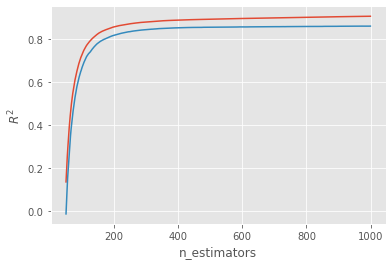

In [20]:
start = 50
end   = 1000

plt.plot(steps[start:end], trainR2[start:end],label='train')
plt.plot(steps[start:end], testR2[start:end],label='test')
plt.xlabel('n_estimators')
plt.ylabel(r'$R^2$')

In [21]:
# this cell is used for parameter tuning, commented out due to long run time

# LR = {'n_estimators':[100, 200, 300, 350, 400, 500], \
#       'max_depth':[2,3,4,5], 'max_features': [2, 3, 4, 5]}

# tuning = GridSearchCV(estimator = GradientBoostingRegressor(),
#                      param_grid = LR, scoring = 'r2')

# tuning.fit(X_train, y_train)
# tuning.best_params_, tuning.best_score_

In [22]:
gbm.set_params(learning_rate=0.03, n_estimators=375, max_depth=2, max_features=4, subsample=.9, warm_start=False)
gbm.fit(X_train, y_train)
print('-'*50)
print("The train set R^2 is %.3f" %(gbm.score(X_train, y_train)))
print("The test set R^2 is %.3f" %(gbm.score(X_test, y_test)))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1112           0.0038            0.37s
         2           0.1076           0.0030            0.37s
         3           0.1036           0.0041            0.37s
         4           0.1019           0.0031            0.37s
         5           0.0987           0.0039            0.37s
         6           0.0955           0.0033            0.37s
         7           0.0946           0.0027            0.37s
         8           0.0899           0.0024            0.37s
         9           0.0876           0.0028            0.33s
        10           0.0856           0.0026            0.33s
        20           0.0636           0.0018            0.28s
        30           0.0509           0.0011            0.28s
        40           0.0416           0.0006            0.25s
        50           0.0339           0.0006            0.24s
        60           0.0287           0.0004            0.24s
       

In [23]:
# generate a final model using the entire dataset

model = gbm.fit(X, y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1149           0.0036            0.37s
         2           0.1117           0.0032            0.37s
         3           0.1081           0.0039            0.37s
         4           0.1048           0.0034            0.37s
         5           0.1006           0.0032            0.37s
         6           0.0990           0.0026            0.37s
         7           0.0969           0.0027            0.37s
         8           0.0932           0.0026            0.37s
         9           0.0902           0.0027            0.37s
        10           0.0854           0.0032            0.36s
        20           0.0653           0.0018            0.32s
        30           0.0514           0.0011            0.30s
        40           0.0414           0.0007            0.28s
        50           0.0344           0.0005            0.27s
        60           0.0292           0.0003            0.26s
       

In [24]:
gbm.score(X, y)

0.8979015490244656

In [25]:
# expect similar result to above
y_pred = model.predict(X)
r2_score(y_pred, y)

0.8828490267974244

# Feature Importance

In [26]:
importance = sorted(list(zip(X.columns, list(gbm.feature_importances_))), key=lambda t:t[1], reverse=True)

Text(0.5, 1.0, 'feature importance of a gbm classifier')

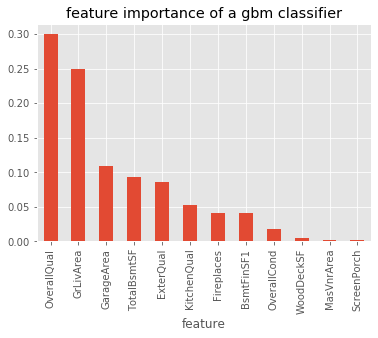

In [27]:
a, b = zip(*importance)
importance_score = pd.DataFrame({'feature':a, 'score':b})
importance_score.plot.bar(x='feature', y='score', legend=None)
plt.title('feature importance of a gbm classifier')

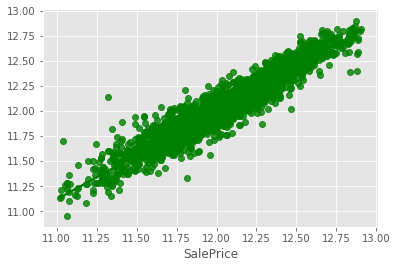

In [29]:
sns.regplot(x=y, y=y_pred, fit_reg=True, color='green', label='Gradient Boost')